Interactively figure out MGRS tiles and track numbers

In [145]:
import asf_search as asf
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import force_2d
from rasterio.crs import CRS
import pandas as pd
import yaml
from pathlib import Path
from tqdm import tqdm
import rasterio
import numpy as np
from asf_search import ASFSession
import http.cookiejar
from dem_stitcher.geojson_io import read_geojson_gzip
import backoff
from skimage.restoration import denoise_tv_bregman
import matplotlib.pyplot as plt

# Load Event Data

In [146]:
yaml_file = 'events/chiapas_fire_2024.yml'
with open(yaml_file) as f:
    event_dict = yaml.safe_load(f)["event"]
event_dict

{'event_name': 'chiapas_fire_2024',
 'bounds': [-94.61821887, 16.40055876, -93.99189954, 16.86321617],
 'event_date': '2024-03-28',
 'pre_event_window_days': 100,
 'post_event_window_days': 60,
 'rtc_track_numbers': [7],
 'mgrs_tiles': ['15QUU'],
 'dist_hls_confirmed_change_min_days': 30,
 'source_id': 'Copernicus EMSR717',
 'links': ['data: https://rapidmapping.emergency.copernicus.eu/EMSR717',
  'https://earthobservatory.nasa.gov/images/152628/fire-in-southern-mexico',
  'etin-171-copernicus-emergency-management-service-monitors-wildfires-mexico']}

# Read Geojson

In [147]:
p_json = Path(f'external_validation_data_db/{event_dict["event_name"]}.geojson')
p_parq = Path(f'external_validation_data_db/{event_dict["event_name"]}.parquet')
if p_json.exists():
    df_event = gpd.read_file(p_json)
else:
    df_event = gpd.read_parquet(p_parq)

In [148]:
# df_event.plot()

In [149]:
df_event.head()

,name,date,source_id,geometry
0,chiapas_fire_2024,2024-03-28,Copernicus Copernicus EMSR717,"MULTIPOLYGON (((-94.53755 16.46818, -94.53770 ..."


In [150]:
df_event.total_bounds

array([-94.61821887,  16.40055876, -93.99189954,  16.86321617])

# Create Spatial AOI

In [151]:
aoi = box(*df_event.total_bounds)
df_aoi = gpd.GeoDataFrame(geometry=[aoi], crs=CRS.from_epsg(4326))

In [152]:
bounds = aoi.bounds
bounds

(-94.61821886599995, 16.400558757000056, -93.99189953799998, 16.86321616500004)

# Find MGRS tiles and Explore

In [153]:
df_mgrs = gpd.read_parquet('mgrs.parquet')
df_mgrs_overlapping = df_mgrs[df_mgrs.geometry.intersects(aoi)].reset_index(drop=True)
# remove antimeridian
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(-180, -60, -179, 60))]
df_mgrs_overlapping = df_mgrs_overlapping[~df_mgrs_overlapping.intersects(box(179, -60, 180, 60))]

df_mgrs_overlapping.head()

,tile_id,epsg,utm_wkt,geometry
1,15QUU,32615,"MULTIPOLYGON(((300000 1900020,300000 1790220,4...","MULTIPOLYGON (((-94.88042 17.17623, -94.87075 ..."


In [154]:
m = df_mgrs_overlapping.explore(column='tile_id', categorical=True)
df_aoi.exterior.explore(m=m, style_kwds={'color':'black'})

# Select MGRS Tile(s)

In [155]:
MGRS_TILES = event_dict['mgrs_tiles']
MGRS_TILES

['15QUU']

In [156]:
df_mgrs_search = df_mgrs_overlapping[df_mgrs_overlapping.tile_id.isin(MGRS_TILES)].reset_index(drop=True)
search_geo = df_mgrs_search.geometry.unary_union

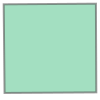

In [157]:
search_geo

# Explore Availability of RTC Data

In [158]:
import datetime
EVENT_DT = datetime.datetime.strptime(event_dict['event_date'], "%Y-%m-%d")
PRE_DT_START = EVENT_DT - datetime.timedelta(days=event_dict['pre_event_window_days'])
POST_DT_STOP = EVENT_DT + datetime.timedelta(days=event_dict['post_event_window_days'])


In [159]:
resp_pre = asf.geo_search(intersectsWith=search_geo.wkt,
                          processingLevel='RTC',
                          platform=asf.constants.SENTINEL1, 
                          start=PRE_DT_START, 
                          end=EVENT_DT)
len(resp_pre)

328

In [160]:
resp_post = asf.geo_search(intersectsWith=search_geo.wkt,
                           processingLevel='RTC',
                           platform=asf.constants.SENTINEL1, 
                           start=EVENT_DT, 
                           end=POST_DT_STOP)
len(resp_post)

196

In [161]:
df_rtc_resp_pre_e = gpd.GeoDataFrame.from_features(resp_pre.geojson(), crs=CRS.from_epsg(4326))
#df_rtc_resp_pre_e = df_rtc_resp_pre_e[df_rtc_resp_pre_e.pathNumber == 130].reset_index(drop=True)
df_rtc_resp_pre_e['geometry'] = df_rtc_resp_pre_e['geometry'].boundary
m = df_rtc_resp_pre_e.explore(alpha=.1, column='pathNumber', categorical=True, cmap='tab20c')
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)
df_aoi.explore(m=m)
m

In [164]:
df_rtc_resp_pre_e.pathNumber.unique()

array([ 34, 172, 107])

In [163]:
df_rtc_resp_post_e = gpd.GeoDataFrame.from_features(resp_post.geojson(), crs=CRS.from_epsg(4326))
# df_rtc_resp_post_e = df_rtc_resp_post_e[df_rtc_resp_post_e.pathNumber.isin([30, 51])].boundary.reset_index(drop=True)
m = df_rtc_resp_post_e.explore()
if MGRS_TILES is not None:
    df_mgrs_search.explore(m=m)

m

In [85]:
df_rtc_resp_post_e.head()

,geometry,centerLat,centerLon,stopTime,fileID,flightDirection,pathNumber,processingLevel,url,startTime,...,validityStartDate,subswath,fileName,beamModeType,s3Urls,beamMode,additionalUrls,bistaticDelayCorrection,noiseCorrection,postProcessingFilter
0,"POLYGON ((7.68137 3.48898, 8.48081 3.65673, 8....",3.656225,8.063784,2024-04-05T17:45:10Z,OPERA_L2_RTC-S1_T030-062306-IW2_20240405T17450...,ASCENDING,30,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-05T17:45:07Z,...,None,IW2,OPERA_L2_RTC-S1_T030-062306-IW2_20240405T17450...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
1,"POLYGON ((8.48139 3.54329, 9.18619 3.69069, 9....",3.700214,8.816562,2024-04-05T17:45:08Z,OPERA_L2_RTC-S1_T030-062305-IW3_20240405T17450...,ASCENDING,30,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-05T17:45:05Z,...,None,IW3,OPERA_L2_RTC-S1_T030-062305-IW3_20240405T17450...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
2,"POLYGON ((7.71592 3.32211, 8.51671 3.49036, 8....",3.489503,8.098625,2024-04-05T17:45:07Z,OPERA_L2_RTC-S1_T030-062305-IW2_20240405T17450...,ASCENDING,30,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-05T17:45:04Z,...,None,IW2,OPERA_L2_RTC-S1_T030-062305-IW2_20240405T17450...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
3,"POLYGON ((8.53800 3.38167, 9.22040 3.52456, 9....",3.535480,8.856314,2024-04-05T17:45:06Z,OPERA_L2_RTC-S1_T030-062304-IW3_20240405T17450...,ASCENDING,30,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-05T17:45:03Z,...,None,IW3,OPERA_L2_RTC-S1_T030-062304-IW3_20240405T17450...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
4,"POLYGON ((7.75051 3.15513, 8.55567 3.32450, 8....",3.322933,8.134642,2024-04-05T17:45:05Z,OPERA_L2_RTC-S1_T030-062304-IW2_20240405T17450...,ASCENDING,30,RTC,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,2024-04-05T17:45:02Z,...,None,IW2,OPERA_L2_RTC-S1_T030-062304-IW2_20240405T17450...,IW,[s3://asf-cumulus-prod-opera-browse/OPERA_L2_R...,IW,[https://datapool.asf.alaska.edu/RTC/OPERA-S1/...,TRUE,TRUE,FALSE
